# Elementos de procesamiento de lenguajes naturales, parte II

Siguiendo nuestra lección anterior, optimizaremos nuestro modelo de red neuronal para crear nombres. Ahora, lo haremos en el estilo del *paper* [Bengio et. al, 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

In [286]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
from pathlib import Path

In [287]:
path = Path('data/')
if not path.is_dir():
  path.mkdir(parents=True, exist_ok=True)

with open(path / 'nombres.txt', 'wb') as f:
  request = requests.get('https://github.com/DanteNoguez/CalculusRatiocinator/raw/main/data/nombres.txt')
  f.write(request.content)

In [288]:
nombres = open('data/nombres.txt', 'r').read().splitlines()
nombres[:8]

['maria', 'rosa', 'jose', 'carmen', 'ana', 'juana', 'antonio', 'elena']

In [289]:
len(nombres)

21029

In [290]:
V = sorted(set(''.join(nombres)))
paf = {p:f+1 for f, p in enumerate(V)}
paf['.'] = 0
fap = {f:p for p,f in paf.items()}
print(fap)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Un modelo neuronal probabilístico de lenguaje

Primero, comenzaremos dividiendo nuestros datos en «bloques». Por ejemplo, en nuestro modelo de bigramas, el bloque contenía un solo carácter, puesto que realizábamos la predicción a partir de una letra; pero podemos aumentar el «contexto» de nuestras predicciones para involucrar más letras al momento de predecir la siguiente. Veamos, por ejemplo, cómo luciría nuestro tratamiento de los datos si hiciéramos bloques de tres caracteres para predecir el siguiente:

In [291]:
def construir_dataset(nombres):
  block_size = 3 # longitud del contexto
  X, Y = [], []
  for n in nombres:
    #print(f'nombre: {n}')
    contexto = [0] * block_size
    for c in n + '.':
      ix = paf[c]
      X.append(contexto)
      Y.append(ix)
      #print(''.join(fap[i] for i in contexto), '----> ', fap[ix])
      contexto = contexto[1:] + [ix]
  
  X = torch.tensor(X) # contexto
  Y = torch.tensor(Y) # objetivo
  return X, Y

```{margin}
“The training set is a sequence $w_1 · · · w_T$ of words $w_t \in V$, where the vocabulary $V$ is a large but finite set.”
```

In [ ]:
construir_dataset(nombres[:3])

nombre: maria
... ---->  m
..m ---->  a
.ma ---->  r
mar ---->  i
ari ---->  a
ria ---->  .
nombre: rosa
... ---->  r
..r ---->  o
.ro ---->  s
ros ---->  a
osa ---->  .
nombre: jose
... ---->  j
..j ---->  o
.jo ---->  s
jos ---->  e
ose ---->  .


(tensor([[ 0,  0,  0],
         [ 0,  0, 13],
         [ 0, 13,  1],
         [13,  1, 18],
         [ 1, 18,  9],
         [18,  9,  1],
         [ 0,  0,  0],
         [ 0,  0, 18],
         [ 0, 18, 15],
         [18, 15, 19],
         [15, 19,  1],
         [ 0,  0,  0],
         [ 0,  0, 10],
         [ 0, 10, 15],
         [10, 15, 19],
         [15, 19,  5]]),
 tensor([13,  1, 18,  9,  1,  0, 18, 15, 19,  1,  0, 10, 15, 19,  5,  0]))

Nuestra intuición detrás de esta aproximación es que el lenguaje funciona mejor con contexto: así como el sentido de un concepto se entiende mejor en contexto, también los caracteres se pueden predecir más razonablemente dado un contexto más amplio. 

Similar a como habíamos hecho anteriormente, construimos una matriz `X` para contener el contexto como entrada y un vector `Y` que contiene el objetivo (es decir, carácter) que debe seguir a cada respectivo contexto. Como se puede apreciar, solamente estamos construyendo `X` e `Y` con sus respectivos índices del vocabulario.

Dado que solo tomamos 3 nombres como ejemplo, nuestros datos únicamente contienen 16 contextos o *inputs* y 16 objetivos o *outputs*:

In [292]:
X, Y = construir_dataset(nombres[:3])
X.shape, Y.shape

(torch.Size([16, 3]), torch.Size([16]))

Ahora estamos listos para hacer el *embedding*. Mientras que en el *paper* los datos se incrustan en una tabla de consulta de 30 dimensiones (o *features*) para un vocabulario de 17,000 palabras, nosotros —que únicamente tenemos un vocabulario de 27 caracteres— podemos aproximarnos a la incrustación con algo más pequeño, como una incrustación de dos dimensiones ($m = 2$).

In [293]:
C = torch.randn((27, 2)) # tabla de consulta
C

tensor([[ 1.1950, -1.6664],
        [ 1.0195, -0.4103],
        [-0.2143,  1.6073],
        [ 1.3569,  1.3905],
        [ 0.7943, -0.9118],
        [ 0.4180,  0.3789],
        [-1.1457,  0.4822],
        [-0.5390, -1.8550],
        [ 0.1015,  1.0336],
        [ 0.1822,  1.7465],
        [ 1.0465,  0.5108],
        [-0.3649,  1.3349],
        [-1.6279, -1.2823],
        [ 0.3673, -1.0746],
        [ 1.4023, -0.8277],
        [ 1.2148, -0.7885],
        [ 0.3532, -0.8317],
        [ 0.4932,  0.6096],
        [-1.4151,  0.7786],
        [ 3.8467, -1.3610],
        [ 1.9704, -0.0231],
        [-0.5216, -0.7434],
        [ 0.9543, -0.3574],
        [ 1.0646, -0.6760],
        [-0.2655, -0.1184],
        [ 2.4975,  0.1847],
        [-2.5699,  0.6519]])

Como vemos, cada *token* o elemento del volcabulario se incrustará en dos dimensiones, es decir, tendrá dos números asociados. Ahora, tomaremos un atajo que nos permitirá ser más eficientes con la codificación y la primera capa de la red neuronal. Anteriormente, habíamos hecho un *one-hot encoding* para luego pasarlo por una capa `W`; pero, bien visto, estos dos pasos pueden ser omitidos porque consiguen el mismo resultado que la incrustación en nuestra tabla `C`. 

Primero: la codificación *one-hot*, si fuéramos a multiplicarla por `C`, anularía todos los valores de `C` al multiplicarlos por 0 y conservaría una fila correspondiente a la de la multiplicación por 1. Ergo, podemos omitir la multiplicación y hacer una indexación para asociar directamente cada carácter con cada fila que un vector *one-hot* multiplicaría por 1. Dicho esto, podemos concebir a `C` como un equivalente de la capa `W`, puesto que consiste de valores aleatorios que asignan un número a cada carácter y luego pueden optimizarse con propagación hacia atrás.

Dicho esto, la indexación (*embedding*) será bastante simple:

```{margin}
“A mapping $C$ from any element $i$ of $V$ to a real vector $C(i) \in \mathbb{R}^m$. It represents the distributed feature vectors associated with each word in the vocabulary. In practice, C is represented by a $\left|V\right| \times m$ matrix of free parameters”.
```

In [295]:
emb = C[X] # embedding

f'Segunda fila de C: {C[1].numpy()} | Tercer valor del tercer bloque incrustado (es decir, letra a): {emb[2][2].numpy()}'

'Segunda fila de C: [ 1.0194591  -0.41030166] | Tercer valor del tercer bloque incrustado (es decir, letra a): [ 1.0194591  -0.41030166]'

In [296]:
print('Dimensiones del embedding: ', emb.shape) 
print('Tres bloques del embedding, correspondientes a «..m», «.ma» y «mar»:', emb[1:4])

Dimensiones del embedding:  torch.Size([16, 3, 2])
Tres bloques del embedding, correspondientes a «..m», «.ma» y «mar»: tensor([[[ 1.1950, -1.6664],
         [ 1.1950, -1.6664],
         [ 0.3673, -1.0746]],

        [[ 1.1950, -1.6664],
         [ 0.3673, -1.0746],
         [ 1.0195, -0.4103]],

        [[ 0.3673, -1.0746],
         [ 1.0195, -0.4103],
         [-1.4151,  0.7786]]])


Ahora, echemos un vistazo a la arquitectura que deseamos lograr:

```{figure} ../../img/bengio2003.png
---
width: 70%
name: bengio2003
---
Arquitectura neuronal $f\left(i, w_{t-1}, \cdots, w_{t-n+1}\right)=g\left(i, C\left(w_{t-1}\right), \cdots, C\left(w_{t-n+1}\right)\right)$ donde $g$ es la red neuronal y $C(i)$ es el $i$-ésimo vector de cada palabra. En nuestro caso, utilizamos bloques de tres letras (`contexto`, vector `X`) en lugar de palabras ($w$).
```

Como vemos, tenemos casi terminado el inicio y únicamente nos falta concatenar entre sí los bloques del *embedding*, puesto que juntos atravesarán la misma capa de neuronas.
```{margin}
“\[...] $x$ is the word features layer activation vector, which is the concatenation of the input word features from the matrix $C$: $x = C\left(w_{t-1}\right), \left(w_{t-2}\right) \cdots, C\left(w_{t-n+1}\right)$.”
```
Para conseguirlo, podemos utilizar distintos métodos con PyTorch:

In [297]:
metodo1 = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)
print(f"""Ahora, en lugar de estar contenidos en bloques de tres filas: 
{emb[0]}
Estarían contenidos en bloques de una fila (seis columnas):
{metodo1[0]}""")

Ahora, en lugar de estar contenidos en bloques de tres filas: 
tensor([[ 1.1950, -1.6664],
        [ 1.1950, -1.6664],
        [ 1.1950, -1.6664]])
Estarían contenidos en bloques de una fila (seis columnas):
tensor([ 1.1950, -1.6664,  1.1950, -1.6664,  1.1950, -1.6664])


In [298]:
metodo2 = torch.cat(torch.unbind(emb, 1), 1)
f'Aunque también es equivalente: {metodo2[0]}'

'Aunque también es equivalente: tensor([ 1.1950, -1.6664,  1.1950, -1.6664,  1.1950, -1.6664])'

Pero el método más eficiente[^1] y simple es `view`. Como primer argumento, colocaremos `-1` para que de esta forma PyTorch infiera el tamaño de la dimensión 0 que debería tener el tensor (sería, pues, equivalente a colocar `emb[0].shape`), y como segundo argumento `6` porque queremos que el tensor tenga las 6 columnas correspondientes a un bloque de tres *tokens*:

In [299]:
emb.view(-1, 6)[0], emb.view(-1, 6).shape # esta es la variable x del paper

(tensor([ 1.1950, -1.6664,  1.1950, -1.6664,  1.1950, -1.6664]),
 torch.Size([16, 6]))

Ahora ya tenemos lo suficiente para definir más variables:

> “Let $h$ be the number of hidden units[^2], and $m$ the number of features associated with each word. When no direct connections from word features to outputs are desired, the matrix $W$ is set to 0 . The free parameters of the model are the output biases $b$ (with $|V|$ elements), the hidden layer biases $d$ (with $h$ elements), the hidden-to-output weights $U$ (a $|V| \times h$ matrix), the word features to output weights $W$ (a $|V| \times(n-1) m$ matrix), the hidden layer weights $H$ (a $h \times(n-1) m$ matrix), and the word features $C$(a $|V| \times m$ matrix $)$: $\theta=(b, d, W, U, H, C)$”.

In [320]:
f'Número de features (m), es decir, número de componentes de cada bloque: {C.size(dim=1)} | Número de elementos por bloque «(n-1)m»: {emb.view(-1, 6).size(dim=1)} | Elementos de |V|: {len(V)+1}'

'Número de features (m), es decir, número de componentes de cada bloque: 2 | Número de elementos por bloque «(n-1)m»: 6 | Elementos de |V|: 27'

El número de parámetros ($h$) depende del problema a tratar: generalmente, a mayor cantidad de datos, es mejor mayor cantidad de parámetros. En general, cuestiones técnicas como esta dependen de la evaluación experimental que hagamos de nuestro modelo: tras pruebas con diferentes números de parámetros, podemos elegir la que más efectiva y eficiente sea. En el *paper*, por ejemplo, probaron con 50 y 100 *hidden units*. Dado que por el momento solo estamos ejemplificando con tres nombres, $h = 50$ unidades serán suficientes.

Por otra parte, fijar un valor de 0 a $W$ es igual que no utilizarla, de manera que omitiremos su definición porque no la necesitamos.

In [301]:
h = 50
d = torch.randn((h))
H = torch.randn((6, h))

a = torch.tanh(emb.view(-1, 6) @ H + d)
a.shape

torch.Size([16, 50])

Ahora, la capa oculta previa al *output*, es decir, la *hidden-to-output layer* se compone de $U$ y $b$, mientras que el resultado de esta capa son —el lector lo recordará— lo que llamamos *logits*, es decir, el resultado de la última capa de la red neuronal. Estos *logits* serán convertidos en  probabilidades y, con ello, tendremos el *output* de toda la red. 

In [302]:
U = torch.randn((h, 27))
b = torch.randn(27)

logits = a @ U + b
logits.shape

torch.Size([16, 27])

Ahora, para convertir esto en probabilidades, haremos lo mismo que en la lección pasada:

In [303]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob[0].sum()

tensor(1.0000)

Para crear nuestra función de pérdida, necesitamos seleccionar nuestros objetivos (con base en el índice que nos dio `Y`):

In [304]:
prob[torch.arange(16), Y]

tensor([2.7201e-07, 1.4083e-02, 5.6987e-07, 3.5629e-07, 9.4318e-10, 4.6116e-08,
        2.3890e-10, 9.0728e-04, 2.6708e-06, 2.7046e-05, 1.8723e-08, 2.6864e-07,
        7.6290e-06, 8.3047e-06, 1.6912e-09, 1.4596e-08])

Ejemplifiquemos: si nuestro *input* es «mar» (`emb[3]`), nuestra probabilidad debe ser alta para que el número del *embedding* que represente la letra «i» de «María» sea un *output*:

In [305]:
print(f"""En un inicio, cada letra de «mar» correspondía a su índice en el vocabulario: {X[3]}
Cuando pasamos estos índices a una matriz para que fueran representados por dos números, obtuvimos: {emb[3]}
Al mismo tiempo, la letra «i» fue guardada como objetivo en Y, siendo su índice: {Y[3]}
De manera que la probabilidad de nuestra red neuronal debe ser alta para el número que representa la letra «i» en el embedding: {-prob[3, Y[3]]}""")

En un inicio, cada letra de «mar» correspondía a su índice en el vocabulario: tensor([13,  1, 18])
Cuando pasamos estos índices a una matriz para que fueran representados por dos números, obtuvimos: tensor([[ 0.3673, -1.0746],
        [ 1.0195, -0.4103],
        [-1.4151,  0.7786]])
Al mismo tiempo, la letra «i» fue guardada como objetivo en Y, siendo su índice: 9
De manera que la probabilidad de nuestra red neuronal debe ser alta para el número que representa la letra «i» en el embedding: -3.5628877981253027e-07


Dado que no hemos entrenado la red, la probabilidad anterior es muy baja. Para poder entrenarla, formularemos la función de pérdida mediante el promedio del logaritmo natural de las probabilidades que la red neuronal asigna a cada objetivo, y finalmente hacemos de este un número positivo al multiplicarlo por $-1$, igual que en la lección pasada:

In [306]:
perdida = -prob[torch.arange(16), Y].log().mean()
perdida

tensor(14.5898)

Usando PyTorch, podemos simplificar todo este proceso mediante el uso de `cross_entropy`:

In [307]:
F.cross_entropy(logits, Y)

tensor(14.5898)

Finalmente, agrupamos los parámetros —$\theta$— en una variable:

In [308]:
parametros = [b, d, U, H, C]

Indicamos a PyTorch que requeriremos gradientes para el entrenamiento de nuestros parámetros:

In [309]:
for p in parametros:
  p.requires_grad = True

Finalmente, podemos entrenar la red:

In [310]:
for i in range(100):
  # paso hacia delante
  emb = C[X]
  h = torch.tanh(emb.view(-1, 6) @ H + d)
  logits = h @ U + b
  perdida = F.cross_entropy(logits, Y)
  
  # propagación hacia atrás
  for p in parametros:
    p.grad = None
  perdida.backward()
  
  for p in parametros:
    p.data += -0.1 * p.grad

print(perdida.item())

0.25268855690956116


Bien, hemos conseguido un resultado decente en nuestro ejemplo. Ahora es momento de entrenar nuestra red con todos los nombres a la vez. 

### Optimización de modelos neuronales: conjuntos de datos, sobreajuste, tasa de aprendizaje y lotes

Primero hacen falta algunos ajustes. Por una parte, evitaremos que nuestro modelo «memorice» o «sobreajuste» cada *output* correspondiente a cada *input* (a este sobreajuste se le llama *overfitting*), puesto que queremos nombres nuevos y originales y no una regurgitación de los que estamos utilizando. Para ello, se han desarrollado un número de técnicas en *deep learning*; pero de momento, utilizaremos una de las más elementales, y consiste en separar nuestros datos en tres partes: entrenamiento, validación y prueba. Entrenaremos nuestro modelo con una cantidad razonable de nombres (el 80 % de ellos), definimos nuestros parámetros —en rigor, hiperparámetros[^3]— con los datos de validación (10 % de nuestros nombres) y verificamos que el modelo sepa generalizar su aprendizaje con los datos destinados a las pruebas (último 10 % de nombres).

In [402]:
import random
random.shuffle(nombres)
n1 = int(0.8*len(nombres))
n2 = int(0.9*len(nombres))

Xtr, Ytr = construir_dataset(nombres[:n1])
Xdev, Ydev = construir_dataset(nombres[n1:n2])
Xte, Yte = construir_dataset(nombres[n2:])
X, Y = construir_dataset(nombres)

X.shape, Xtr.shape, Xdev.shape, Xte.shape

(torch.Size([165469, 3]),
 torch.Size([132418, 3]),
 torch.Size([16559, 3]),
 torch.Size([16492, 3]))

Ahora definimos nuestros hiperparámetros, aunque esta vez utilizaremos $h = 100$:

In [409]:
C = torch.randn(27, 2)
emb = C[Xtr]
h = 100
H = torch.randn((6, h))
d = torch.randn(h)

a = torch.tanh(emb.view(-1, 6) @ H + d)

U = torch.randn(h, 27)
b = torch.randn(27)

logits = a @ U + b

parametros = [C, H, d, U, b]

Nuestro número total de parámetros resultantes es:

In [404]:
sum(p.numel() for p in parametros)

3481

Por otro lado, podemos acelerar el entrenamiento de la red neuronal de la siguiente forma: en cada repetición del *loop* de aprendizaje, podemos seleccionar un «lote» (*batch*) o segmento de los datos para únicamente llevar a cabo el proceso de aprendizaje en ese mismo lote, de manera que el modelo no se entrene tomando siempre en consideración todos los datos a la vez, sino datos —en este caso, nombres— aleatorios en cada iteración. Aunque esto implique sacrificar en cierta medida el desempeño de la red neuronal, sin embargo ese sacrificio se compensa con la rapidez que podemos generar a cambio.

Para crear estos lotes, podemos utilizar el siguiente código, el cual generará índices correspondientes a 32 nombres aleatorios de entre aquellos que pertenezcan a nuestros datos:

In [391]:
ix = torch.randint(0, X.shape[0], (32,))
f'Tres ejemplos: {ix[:3].numpy()}'

'Tres ejemplos: [123401  87687  70020]'

Finalmente, nos falta tratar los detalles técnicos detrás de la *learning rate* («tasa de aprendizaje») del modelo. Recordemos que, cuando modificamos los parámetros en la dirección del gradiente, generalmente atenuamos al gradiente multiplicándolo por un número pequeño para así no excedernos en el ajuste, consiguiendo una pérdida cercana a 0 sin sobrepasarla.

Para determinar una *learning rate* razonable, tenemos que averiguar empíricamente los «límites» de la misma:

In [410]:
for p in parametros:
  p.requires_grad = True

In [393]:
for _ in range(10):
  #minibatch («minilote»)
  ix = torch.randint(0, Xdev.shape[0], (32,))

  # propagación hacia delante
  emb = C[Xdev[ix]]
  a = torch.tanh(emb.view(-1, 6) @ H + d)
  logits = a @ U + b
  perdida = F.cross_entropy(logits, Ydev[ix])
  print(perdida.item())
  
  # propagación hacia atrás
  for p in parametros:
    p.grad = None
  perdida.backward()

  # actualización
  lr = -1 # intentaremos obtener el límite superior
  for p in parametros:
    p.data += lr * p.grad

22.080612182617188
18.37497329711914
15.564812660217285
15.621807098388672
17.045852661132812
18.507583618164062
21.449209213256836
21.56830596923828
24.576093673706055
15.103194236755371


Como vemos, la pérdida disminuye con una tasa de aprendizaje de -1; pero al mismo tiempo indica que esta tasa es muy alta porque no es nada estable y se balancea hacia arriba y abajo. Este puede ser nuestro límite superior, busquemos el inferior:

In [394]:
for _ in range(10):
  #minibatch («minilote»)
  ix = torch.randint(0, Xdev.shape[0], (32,))

  # propagación hacia delante
  emb = C[Xdev[ix]]
  a = torch.tanh(emb.view(-1, 6) @ H + d)
  logits = a @ U + b
  perdida = F.cross_entropy(logits, Ydev[ix])
  print(perdida.item())
  
  # propagación hacia atrás
  for p in parametros:
    p.grad = None
  perdida.backward()

  # actualización
  lr = -0.001 # intentaremos obtener el límite inferior
  for p in parametros:
    p.data += lr * p.grad

16.730724334716797
19.113916397094727
16.265771865844727
16.343080520629883
19.638389587402344
17.050613403320312
16.68904685974121
23.818950653076172
16.777978897094727
20.498703002929688


De igual forma, esta pérdida es subóptima porque es demasiado lenta para eficientar el aprendizaje, de manera que este puede ser nuestro límite inferior. Ahora, haremos una prueba de entrenamiento con tasas de aprendizaje que se encuentren dentro de estos límites; pero, para que nuestra tasa de aprendizaje no cambie lineal sino exponencialmente, podemos utilizar nuestros números como potencias de 10. Es decir, en teoría, nuestras tasas de aprendizaje serían mil números del 0.001 al 1:

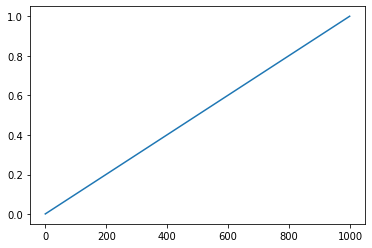

In [395]:
lr = torch.linspace(0.001, 1, 1000)

plt.plot(lr.numpy());

Pero $10^{-3} = 0.001$ y $10{^0} = 1$, de manera que utilizar este truco nos ayuda a obtener un cambio exponencial en nuestras tasas de aprendizaje. Ahora, nuestros 1000 números serán exponentes de 10 y lucirán así:

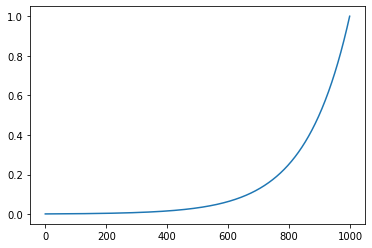

In [396]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

plt.plot(lrs.numpy());

Ahora, para elegir el número correcto en este rango, podemos registrar nuestras pérdidas correspondientes a cada tasa durante el entrenamiento:

In [406]:
lr_i = []
perdidas_i = []

for i in range(1000):
  #minibatch («minilote»)
  ix = torch.randint(0, Xdev.shape[0], (32,))

  # propagación hacia delante
  emb = C[Xdev[ix]]
  a = torch.tanh(emb.view(-1, 6) @ H + d)
  logits = a @ U + b
  perdida = F.cross_entropy(logits, Ydev[ix])
  #print(perdida.item())
  
  # propagación hacia atrás
  for p in parametros:
    p.grad = None
  perdida.backward()

  # actualización
  lr = lrs[i] # intentaremos obtener el límite inferior
  for p in parametros:
    p.data += -lr * p.grad

  # registrar estadísticas
  lr_i.append(lre[i])
  perdidas_i.append(perdida.item())

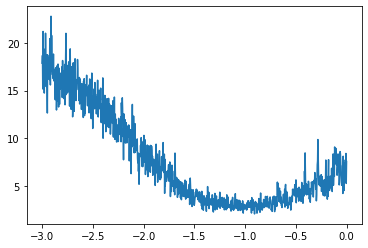

In [407]:
plt.plot(lr_i, perdidas_i);

En el gráfico podemos apreciar que nuestra tasa de aprendizaje óptima —es decir, la que mejor minimiza la pérdida— se encuentra alrededor de $10^{-1}$ (es decir, $0.1$), de manera que podemos utilizar esta tasa con mayor confianza para entrenar todos nuestros parámetros con los datos de `Xtr`.

In [411]:
paso_i = []
perdidas_i = []

for i in range(1000):
  #minibatch («minilote»)
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # propagación hacia delante
  emb = C[Xtr[ix]]
  a = torch.tanh(emb.view(-1, 6) @ H + d)
  logits = a @ U + b
  perdida = F.cross_entropy(logits, Ytr[ix])
  
  # propagación hacia atrás
  for p in parametros:
    p.grad = None
  perdida.backward()

  # actualización
  lr = 0.1 # nueva tasa
  for p in parametros:
    p.data += -lr * p.grad

  # registrar estadísticas
  paso_i.append(i)
  perdidas_i.append(perdida.item())

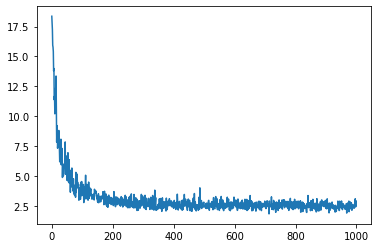

In [413]:
plt.plot(paso_i, perdidas_i);

Debido a que entrenamos nuestros parámetros en lotes, la función de pérdida tiene algo de ruido cuando se acerca a su valor mínimo. Comprobemos ahora la pérdida que tenemos en `Xdev`:

In [414]:
emb = C[Xdev]
a = torch.tanh(emb.view(-1, 6) @ H + d)
logits = a @ U + b
perdida = F.cross_entropy(logits, Ydev)
perdida

tensor(2.4327, grad_fn=<NllLossBackward0>)

Finalmente, podemos visualizar cómo luce nuestro *embedding* ahora que ha sido entrenado:

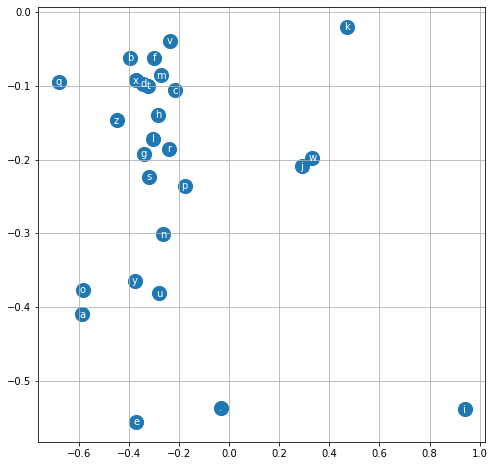

In [428]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), fap[i], ha='center', va='center', color='white')
plt.grid('minor');

Como vemos, las vocales —junto con la «y», aunque sin la «i»— aparecen agrupadas entre sí: esto quiere decir que nuestro modelo las interpreta como letras similares. Lo mismo aplica para las consonantes.

Hasta el momento, no hemos conseguido mejorar nuestro modelo anterior. En la práctica, la optimización de modelos se hace con un número de pruebas que contengan hiperparámetros distintos. Podemos, por ejemplo, aumentar nuestros parámetros, nuestro *embedding*, nuestras capas, probar nuevas tasas de aprendizaje, entrenar el modelo por más tiempo, etcétera. Intentemos hacer un poco de todo para finalizar esta lección:

### Ensayo de un modelo con hiperparámetros óptimos

In [445]:
random.shuffle(nombres)
n1 = int(0.8*len(nombres))
n2 = int(0.9*len(nombres))

Xtr, Ytr = construir_dataset(nombres[:n1])
Xdev, Ydev = construir_dataset(nombres[n1:n2])
Xte, Yte = construir_dataset(nombres[n2:])
X, Y = construir_dataset(nombres)

C = torch.randn(27, 10) # un embedding de 10 dimensiones
h = 200 # aumentamos las unidades ocultas a 200
H = torch.randn((30, h)) # recordemos: 10 * 3 = 30
d = torch.randn(h)
U = torch.randn(h, 27)
b = torch.randn(27)

parametros = [C, H, d, U, b]

In [446]:
for p in parametros:
  p.requires_grad = True

for i in range(15000):
  #minibatch («minilote»)
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # propagación hacia delante
  emb = C[Xtr[ix]]
  a = torch.tanh(emb.view(-1, 30) @ H + d)
  logits = a @ U + b
  perdida = F.cross_entropy(logits, Ytr[ix])
  
  # propagación hacia atrás
  for p in parametros:
    p.grad = None
  perdida.backward()

  # actualización
  lr = 0.1 if i < 14000 else 0.01 # nuestra tasa de aprendizaje disminuirá hacia el final del entrenamiento
  for p in parametros:
    p.data += -lr * p.grad

print(perdida.item())

1.7781141996383667


Finalmente hemos superado al modelo anterior con fuerza bruta. Aunque podríamos seguir ajustándolo, me parece que esto será suficiente para obtener mejores muestras de nombres. Revisemos la pérdida de nuestros `Xdev` y `Xte` para cerciorarnos de que nuestro modelo haya generalizado sus aprendizajes, en vez de memorizarlos:

In [448]:
emb = C[Xdev]
a = torch.tanh(emb.view(-1, 30) @ H + d)
logits = a @ U + b
perdida = F.cross_entropy(logits, Ydev)
perdida

tensor(1.9739, grad_fn=<NllLossBackward0>)

In [449]:
emb = C[Xte]
a = torch.tanh(emb.view(-1, 30) @ H + d)
logits = a @ U + b
perdida = F.cross_entropy(logits, Yte)
perdida

tensor(1.9782, grad_fn=<NllLossBackward0>)

Tenemos también pérdidas razonables para ambos conjuntos de datos. Conforme la pérdida del entrenamiento difiera más de las otras dos (`Xdev` y `Xte`), esto indicaría que nuestros parámetros están memorizando los datos, no generalizándolos. En ese sentido, debemos ser cuidados de no sobreentrenar, ni tampoco sobredimensionar el modelo, puesto que si nos excedemos, terminará memorizando todos nuestros datos.

Para finalizar, obtengamos algunas muestras de nombres generados por nuestro modelo:

In [455]:
block_size = 3
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    a = torch.tanh(emb.view(1, -1) @ H + d)
    logits = a @ U + b
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(fap[i] for i in out))

cedelzorena.
carixto.
leiscasiria.
jovino.
renta.
marizio.
alfidela.
alsa.
paulogia.
taw.
migdina.
duboa.
secahmidio.
sihorgel.
floreta.
remenicia.
penoyda.
filiano.
frinda.
geria.


Indudablemente, estos nombres son más respetables.

[^1]: El método `view` es eficiente porque [no requiere de nuevo espacio](http://blog.ezyang.com/2019/05/pytorch-internals/) en la memoria de nuestra computadora, sino que utiliza el mismo tensor para reacomodarlo de manera distinta. Conforme nuestros programas se vuelvan más complejos, debemos procurar eficientar al máximo nuestros recursos computacionales. Para un acercamiento más general al tema, véase el [artículo de Horace He](https://horace.io/brrr_intro.html).

[^2]: En *deep learning*, el término *hidden* («oculto») se utiliza para referirse a componentes de una red neuronal que no son «visibles» ni como entradas ni como salidas de la red. Se trata de entradas o salidas que se procesan internamente por la red neuronal antes de arrojar un resultado final. La *hidden unit*, en ese sentido, se refiere a cada unidad o componente de una capa oculta (*hidden layer*) en la red. Podemos entenderla como sinónimo de «nodo» o «neurona».

[^3]: Se denominan «parámetros» a los números o coeficientes que la red neuronal aprende y determina durante el entrenamiento (por ejemplo, los números de los pesos y los sesgos). Por otra parte, los «hiperparámetros» son aquellos que nosotros definimos manualmente según la naturaleza de cada problema, y que optimizamos mediante pruebas con distintos valores (por ejemplo, nuestras unidades ocultas $h$).